In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import interpolate
import math
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import Rbf

In [3]:
x_i = 196
y_j = 128
number = x_i*y_j
file_name = '/home/haoyan/Desktop/ML-CFD/CASE/PHill/LES_nasa_PHill/hill_LES_avgresults.dat'
raw_data = []

In [11]:
def data_r_o(file_name, i, j):#input (file_name, number of grids in x-direction, number of grids in y-direction)
    number = i * j
    raw_data = []
    with open(file_name) as f:
        for line in f:
            word_list = line.split()
            for i in word_list:
                raw_data.append(float(i))
    raw_data = np.array(raw_data)
    x = raw_data[0:number]
    y = raw_data[number:number*2]
    x = x * 28
    y = y * 28
    p = raw_data[number*2:number*3]
    u = raw_data[number*3:number*4]
    v = raw_data[number*4:number*5]
    w = raw_data[number*5:number*6]
    nut = raw_data[number*6:number*7]
    uu = raw_data[number*7:number*8]
    vv = raw_data[number*8:number*9]
    ww = raw_data[number*9:number*10]
    uv = raw_data[number*10:number*11]
    uw = raw_data[number*11:number*12]
    vw = raw_data[number*12:number*13]
    k = raw_data[number*13:number*14]
    return x,y,p,u,v,w,nut,uu,vv,ww,uv,uw,vw,k 

def data_r_d(file_name, i, j):#input (file_name, number of grids in x-direction, number of grids in y-direction)
    number = i * j
    raw_data = []
    with open(file_name) as f:
        for line in f:
            word_list = line.split()
            for i in word_list:
                raw_data.append(float(i))
    raw_data = np.array(raw_data)
    dudx = raw_data[number*2:number*3]
    dudy = raw_data[number*3:number*4]
    dvdx = raw_data[number*4:number*5]
    dvdy = raw_data[number*5:number*6]
    dwdx = raw_data[number*6:number*7]
    dwdy = raw_data[number*7:number*8]
    return dudx,dudy,dvdx,dvdy,dwdx,dwdy

def mesh_centre(x,y):#input (coordinate in x, coordinate in y) 
    plt.figure(figsize=(90,30.35))
    plt.scatter(x,y,color='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    return 0

def plot_contour_1(x_coordinate,y_coordinate,i,j,field,field_name,bar_n):
    X = np.zeros((j,i))
    Y = np.zeros((j,i))
    Field = np.zeros((j,i))
    for n in range(j):
        X[n,:] = x_coordinate[i*n:i*(n+1)]
        Y[n,:] = y_coordinate[i*n:i*(n+1)]
        Field[n,:] = field[i*n:i*(n+1)]
    fig,ax = plt.subplots(figsize=(20,7.5))
    levels = np.linspace(min(field),max(field),bar_n)
    p1 = ax.contourf(X,Y,Field,levels,cmap=cm.jet)
    #p1 = ax.contourf(X,Y,Field,cmap=cm.jet)
    p2 = ax.contour(X,Y,Field,levels,linewidths=0.5,colors='black')
    p2 = ax.contour(X,Y,Field,linewidths=0.5,colors='y')
    ax.set_xlim(min(x_coordinate), max(x_coordinate))
    ax.set_ylim(min(y_coordinate), max(y_coordinate))
    ax.set_xlabel("$\t{x}$(mm)",size=15)
    ax.set_ylabel("$\t{y}$(mm)",size=15)
    cbar = fig.colorbar(p1)
    cbar.set_label(field_name, size=18)
    plt.show()
    return 0

def plot_contour_2(x_coordinate,y_coordinate,i,j,field,field_name,bar_numbers,Min,Max):
    X = np.zeros((j,i))
    Y = np.zeros((j,i))
    Field = np.zeros((j,i))
    for n in range(j):
        X[n,:] = x_coordinate[i*n:i*(n+1)]
        Y[n,:] = y_coordinate[i*n:i*(n+1)]
        Field[n,:] = field[i*n:i*(n+1)]
    fig,ax = plt.subplots(figsize=(20,7.5))
    levels = list(np.linspace(Min,Max,bar_numbers))
    p1 = ax.contourf(X,Y,Field,levels,cmap=cm.jet,extend='both')
    p2 = ax.contour(X,Y,Field,levels,linewidths=0.5,colors='black',extend='both')
    ax.set_xlim(min(x_coordinate), max(x_coordinate))
    ax.set_ylim(min(y_coordinate), max(y_coordinate))
    ax.set_xlabel("$\t{x}$(mm)",size=15)
    ax.set_ylabel("$\t{y}$(mm)",size=15)
    cbar = fig.colorbar(p1)
    cbar.set_label(field_name, size=18)
    plt.show()
    return 0

def Cal_anisotropy(uu,uv,uw,vv,vw,ww,k):
    B_11 = np.zeros(len(uu))
    B_22 = np.zeros(len(uu))
    B_33 = np.zeros(len(uu))
    B_12 = np.zeros(len(uu))
    B_13 = np.zeros(len(uu))
    B_23 = np.zeros(len(uu))
    for i in range(len(uu)):
        B_11[i] = uu[i]/(2*k[i]) - 1/3
        B_12[i] = uv[i]/(2*k[i]) 
        B_13[i] = uw[i]/(2*k[i]) Not needed for two-dimensional cases
        B_22[i] = vv[i]/(2*k[i]) - 1/3
        B_23[i] = vw[i]/(2*k[i])
        B_33[i] = ww[i]/(2*k[i]) - 1/3
    return B_11,B_12,B_13,B_22,B_23,B_33

def reading_field(head,name,n_package,file_name,i,j):#Reading the raw vector data
    file = head +name +'/'+ n_package + '/' + file_name
    raw_data = []
    number = 23 + (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n')
            raw_data.append(line)
    data_str = (raw_data[23:number])
    data  = [float(i) for i in data_str]
    data = np.array(data)
    return data

In [12]:
x,y,p,U,V,W,nut,uu,vv,ww,uv,uw,vw,k = data_r_o(file_name,x_i,y_j)
dudx,dudy,dvdx,dvdy,dwdx,dwdy = data_r_d(file_name,x_i,y_j)
b_11, b_12, b_13, b_22, b_23, b_33 = Cal_anisotropy(uu, uv, uw, vv, vw, ww, k)
x = x / 28
y = y / 28
#x_RANS = np.load("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/x_coordinate_RANS.npy")
#y_RANS = np.load("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/y_coordinate_RANS.npy")
head ='/home/haoyan/Desktop/ML-CFD/CASE/PHill/Grid-iretation-independency/'
x_RANS = reading_field(head,'h10','0','Cx',140,150)*1000/28
y_RANS = reading_field(head,'h10','0','Cy',140,150)*1000/28


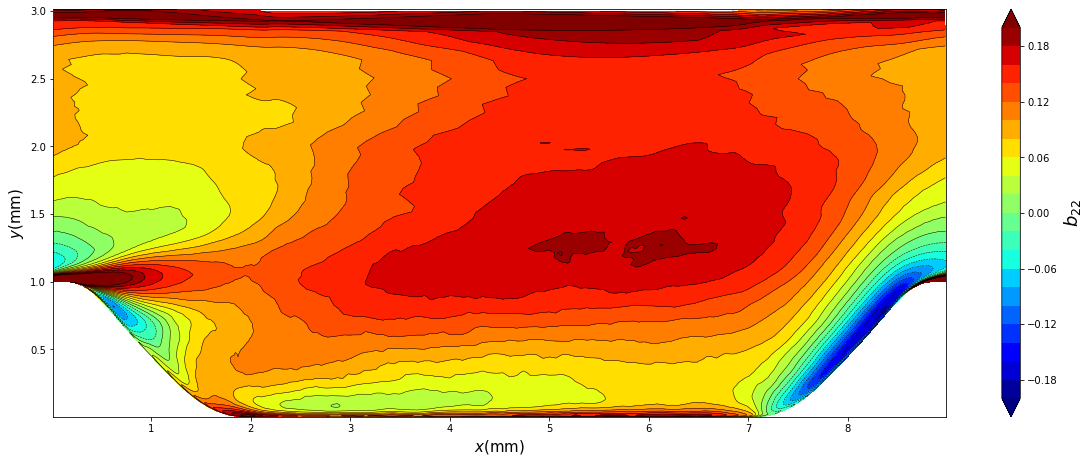

0

In [13]:
plot_contour_2(x,y,x_i,y_j,b_11,'$b_{22}$',21,-0.2,0.2)

In [5]:
#plot_contour_2(x_RANS,y_RANS,140,120,b_11_inter,'$b_{11}$',21,-0.2,0.2)

In [5]:
File_address = '/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/'
End = '.npy'
p_b_address = File_address + 'p_b_TBNN' + End
p_b = np.load(p_b_address)

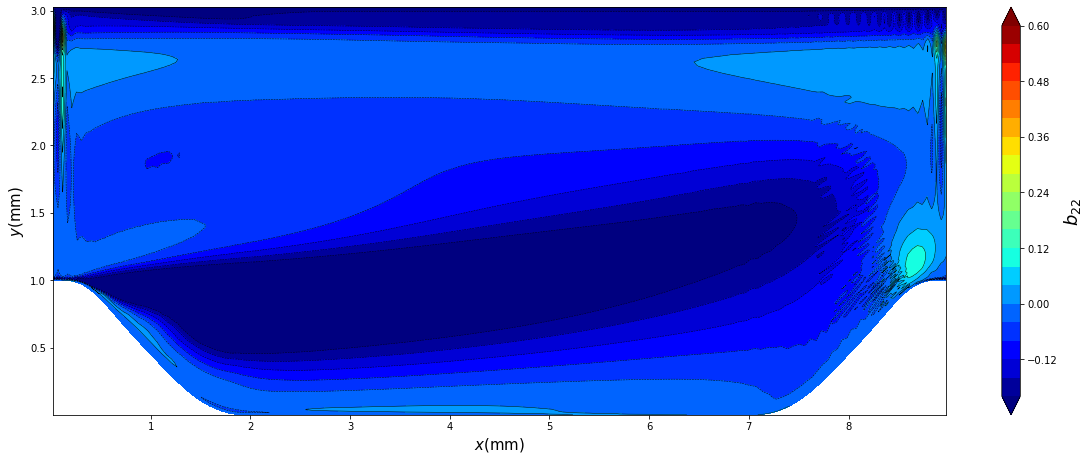

0

In [6]:
plot_contour_2(x_RANS,y_RANS,140,150,p_b[:,0,0],'$b_{22}$',21,-0.2,0.6)

# 

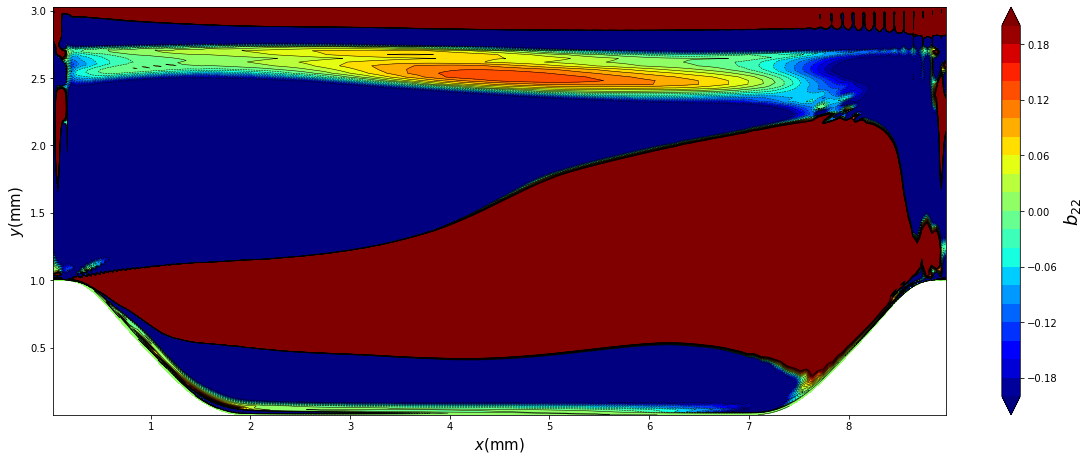

0

In [68]:
plot_contour_2(x_RANS,y_RANS,140,150,p_b[:,0],'$b_{22}$',21,-0.2,0.2)